# 【問題1】仮定関数
ロジスティック回帰の仮定関数のメソッドをScratchLogisticRegressionクラスに実装してください。


ロジスティック回帰の仮定関数は、線形回帰の仮定関数を シグモイド関数 に通したものです。シグモイド関数は以下の式で表されます。

$$g(z) = \frac{1}{1+e^{-\theta^T x}}$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _linear_hypothesis(X, theta):
    """
    線形の仮定関数を計算する
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    theta_T : 次の形のndarray, shape (n_features, 1)
    Returns
    -------
      次の形のndarray, shape (n_samples, 1)
      線形の仮定関数による推定結果
    """
    
    h = 1 / (1 + np.exp(-(X @ theta)))
    
    return h

## 【問題2】最急降下法
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fitメソッドから呼び出すようにしてください。

$$\frac{\partial j(\theta)}{\partial\theta_j} = \frac{1}{m}\sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)}x_j^{(i)})+\frac{\lambda}{m}\theta_j$$

ただしバイアスに対しての更新式は
$$\frac{\partial j(\theta)}{\partial\theta_0} = \frac{1}{m}\sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)}x_j^{(i)})$$
とする。  
バイアスの重みにペナルティを与えない(正則化項の微分を加えない)理由としては、バイアスに関してはペナルティによらず自由に動いてほしいからという理由らしい...  
  
線形回帰とかの正則化項がないモデルとバイアスの値が大きく変わってしまうから？？  
仮にペナルティが大きいとバイアスがないのと同義になってしまうから？

In [2]:
def _gradient_descent(X, y, theta, lr=0.1, lambd = 1.0 ):
    """
    傾きを計算する。
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
    訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
    目的データ
    theta : 次の形のndarray, shape(n_features, 1)
    更新されていく重み
    lr : float
    学習率
    lambd : float
    ペナルティの重み
    Returns
    -------
    次の形のndarray, shape (n_samples, 1)
    更新後のtheta
    """
    for j in range(X.shape[1]):
        
        #
        #バイアス
        #
        if j == 0:
        
            sigma = (X[:, j].T @ (_linear_hypothesis(X, theta) - y))
            theta[j] = theta[j] - ((lr / X.shape[0]) * sigma)
        #
        # バイアス以外
        #
        else:
            
            sigma = (X[:, j].T @ (_linear_hypothesis(X, theta) - y))
            theta[j] = theta[j] - (1 / X.shape[0] * (sigma + lambd  * theta[j]))

    return theta

## 【問題4】目的関数
以下の数式で表されるロジスティック回帰の 目的関数（損失関数） を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。


なお、この数式には正則化項が含まれています。


＊数式が見切れる場合、DIVERを全画面にして御覧ください。

In [3]:
def get_loss(test_X, test_y, theta):
    """
    平均二乗誤差の計算
    Parameters
    ----------
    y_pred : 次の形のndarray, shape (n_samples,)
      推定した値
    y : 次の形のndarray, shape (n_samples,)
      正解値
    theta_T
    Returns
    ----------
    mse : numpy.float
      平均二乗誤差
    """
    # LAMBDA=1と仮定
    
    h = _linear_hypothesis(test_X, theta)
    sigma_1 = (np.log(h).T @ (-1 * test_y)) - (np.log(1 - h).T @ (1 - test_y))
    sigma_2 = theta @ theta.T
    loss = 1 / h.shape[0] * sigma_1 + 0.1 / h.shape[0] * sigma_2

    return loss

# 【問題3】推定
推定する仕組みを実装してください。ScratchLogisticRegressionクラスの雛形に含まれるpredictメソッドとpredict_probaメソッドに書き加えてください。


仮定関数 
h
θ
(
x
)
 の出力がpredict_probaの戻り値、さらにその値に閾値を設けて1と0のラベルとしたものがpredictの戻り値となります。

# 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したirisデータセットのvirgicolorとvirginicaの2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装
    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    verbose : bool
      学習過程を出力する場合はTrue
    C : float
     ペナルティの大きさ
     
    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      重み
    self.intercept_ : 次の形のndarray, shape (1,)
      切片
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録
    """
    
    
    def __init__(self, num_iter, lr, bias=True, verbose=False, C=1.0):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.bias = bias
        self.verbose = verbose
        self.C = C
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
    
    
    def _linear_hypothesis(self, X, theta):
        """
        ロジスティック回帰の仮定関数を計算する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features+1)
        訓練データ
        theta : 次の形のndarray, shape (n_features, 1)
        重み

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果
        """

        h = 1 / (1 + np.exp(-(X @ theta)))

        return h    

    
    def _gradient_descent(self, X, y, theta):
        """
        傾きを計算する。 
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
        訓練データ
        y : 次の形のndarray, shape (n_samples, 1)
        目的データ
        theta : 次の形のndarray, shape(n_features, 1)
        更新されていく重み
        lr : float
        学習率
        Returns
        -------
        次の形のndarray, shape (n_samples, 1)
        更新後のtheta
        """
        for j in range(X.shape[1]):

            #
            #バイアス
            #
            if j == 0:
             
                sigma = (X[:, j].T @ (self._linear_hypothesis(X, theta) - y))
                theta[j] = theta[j] - ((self.lr / X.shape[0]) * sigma)
            #
            # バイアス以外
            #
            else:

                sigma = (X[:, j].T @ (self._linear_hypothesis(X, theta) - y))
                theta[j] = theta[j] - (self.lr / X.shape[0] * (sigma + self.C  * theta[j]))

        return theta
    
    
    def fit(self, train_X, train_y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        
        #
        #バイアス項がある場合
        #
        if self.bias == True:
            
            # X_0の調整
            X_0 = np.ones((train_X.shape[0], 1))
            # X.shape(Xのサンプル数、Xの特徴量数+1)
            X = np.concatenate([X_0, train_X], axis=1)
            # yの設定
            y = train_y.values
            # 重みの設定
            theta = np.zeros((1, X.shape[1]))  
            # theta_T.shape(1,  特徴量数)
            theta_T = theta.T
            #検証データ用のtheta保管
            theta_history = np.zeros((self.iter, X.shape[1]))
            
            
            for i in range(self.iter):
                theta_T = self._gradient_descent(X, y, theta_T)
                self.loss[i] = self.get_loss(X, y, theta_T)
                theta_history[i] = theta_T.T

            # 計算後をグローバルに
            self.last_theta_T = theta_T
            self.coef_ = theta_T.T[:, 1:]
            self.intercept_ = theta_T.T[:, 0]

            # 学習仮定出力
            if self.verbose == True:
                print('学習過程 : {}'.format(self.loss))


            #   
            # 検証データがONのとき
            #
            
            if type(train_X)==type(X_val):

                # X_0の調整
                X_0 = np.ones((X_val.shape[0], 1))
                # X.shape(Xのサンプル数、Xの特徴量数+1)
                X = np.concatenate([X_0, X_val], axis=1)
                # yの設定
                y = y_val.values
                
                # theta_historyを用いた損失関数の指揮を書く
                for i in range(self.iter):
                    theta_T = theta_history[i]
                    theta_T = theta_T.reshape(theta_T.shape[0], 1)
                    self.val_loss[i] = self.get_loss(X, y, theta_T)

                
    def get_loss(self, X, y, theta):
        """
        誤差関数の計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
        訓練データ
        y : 次の形のndarray, shape (n_samples, 1)
        目的データ
        theta : 次の形のndarray, shape(n_features, 1)
        更新されていく重み
        Returns
        ----------
        loss : numpy.float
          誤差
        """

        h = self._linear_hypothesis(X, theta)
        sigma_1 = (np.log(h).T @ (-1 * y)) - (np.log(1 - h).T @ (1 - y))
        sigma_2 = theta.T @ theta
                
        loss = 1 / h.shape[0] * sigma_1 + 0.1 / h.shape[0] * sigma_2

        return loss
    
    def predict(self, test_X):
        """
        ロジスティック回帰を行い、クラス(閾値0.5)で出力
        Parameters
        ----------
        test_X : 次の形のndarray, shape (n_samples, n_features)
        テストデータ

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック解析の結果を閾値0.5でクラス分けしたもの
        """
        # X_0の調整
        X_0 = np.ones((test_X.shape[0], 1))
        # X.shape(Xのサンプル数、Xの特徴量数+1)
        X = np.concatenate([X_0, test_X], axis=1)
        
        y_pred = (self._linear_hypothesis(X, self.last_theta_T) * 2 // 1).astype('int')

        return y_pred
    
    
    def predict_proba(self, test_X):
        """
        ロジスティック回帰を行い、確率(閾値なし)で出力
        Parameters
        ----------
        test_X : 次の形のndarray, shape (n_samples, n_features)
        テストデータ

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック解析の結果
        """
        
        # X_0の調整
        X_0 = np.ones((test_X.shape[0], 1))
        # X.shape(Xのサンプル数、Xの特徴量数+1)
        X = np.concatenate([X_0, test_X], axis=1)

        y_proba = self._linear_hypothesis(X, self.last_theta_T)

        return y_proba
    

## データの読み込み

In [5]:
from sklearn.datasets import load_iris
iris = load_iris()
import pandas as pd
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.DataFrame(iris.target)
y = y.rename(columns={0 : 'Species'})
X = X.iloc[:100]
y = y.iloc[:100]

## 標準化

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

## データ分割

In [7]:
from sklearn.model_selection import train_test_split
X_75, X_25 = train_test_split(X, random_state=0)
y_75, y_25 = train_test_split(y, random_state=0)

## 既存モデルでの分類

In [8]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(penalty='l2', C=1.0, random_state=0, max_iter=100)
LR.fit(X_75, np.ravel(y_75))
LR_pred = LR.predict(X_25)
LR_pred_proba = LR.predict_proba(X_25)

### 評価

In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_25, LR_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        12

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



In [10]:
import sklearn.metrics as me
from sklearn.metrics import roc_auc_score

roc_auc_score(y_25, LR_pred_proba[:, 1])
# print('AUC : {}'.format(roc_auc_score(y_25, LR_pred_proba[:, 0], multi_class='ovr')))

1.0

## 自作モデル
### 検証データ無し

In [11]:
my = ScratchLogisticRegression(num_iter=100, lr=0.2)
my.fit(X_75, y_75)

In [12]:
my.loss

array([0.56811999, 0.47592584, 0.40682322, 0.35395057, 0.31263106,
       0.27968958, 0.25294814, 0.23088751, 0.21242762, 0.19678571,
       0.18338386, 0.17178794, 0.16166659, 0.15276312, 0.144876  ,
       0.13784506, 0.13154155, 0.1258609 , 0.12071737, 0.11604007,
       0.11176989, 0.10785719, 0.10425996, 0.10094249, 0.09787417,
       0.09502868, 0.09238321, 0.08991796, 0.0876156 , 0.08546097,
       0.08344068, 0.08154292, 0.0797572 , 0.07807417, 0.07648552,
       0.07498376, 0.07356219, 0.07221477, 0.07093605, 0.06972109,
       0.0685654 , 0.06746492, 0.06641593, 0.06541503, 0.06445913,
       0.06354539, 0.06267118, 0.06183411, 0.06103195, 0.06026268,
       0.0595244 , 0.05881535, 0.05813393, 0.05747861, 0.05684802,
       0.05624083, 0.05565585, 0.05509193, 0.05454803, 0.05402314,
       0.05351636, 0.0530268 , 0.05255366, 0.05209617, 0.05165361,
       0.05122531, 0.05081064, 0.05040899, 0.0500198 , 0.04964254,
       0.0492767 , 0.04892181, 0.04857741, 0.04824308, 0.04791

In [13]:
my.coef_, LR.coef_

(array([[ 0.73269551, -0.97412727,  1.2617742 ,  1.26632722]]),
 array([[ 0.73155989, -1.06682127,  1.44630388,  1.48672157]]))

In [14]:
my.intercept_, LR.intercept_

(array([0.07474007]), array([0.17201232]))

比較してもそこまで悪くない。  
バイアスの値だけ多少ことなる。

In [15]:
my_pred_proba = my.predict_proba(X_25)
my_pred = my.predict(X_25)

In [16]:
print(classification_report(y_25, my_pred))
print(roc_auc_score(y_25, my_pred_proba))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        12

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

1.0


通常モデルと同じ出来栄えになった。

### 検証データあり

In [17]:
my = ScratchLogisticRegression(num_iter=100, lr=0.2)
my.fit(X_75, y_75, X_25, y_25)

In [18]:
my.val_loss

array([0.56469075, 0.47033607, 0.39993485, 0.3463398 , 0.30468068,
       0.27165351, 0.24499474, 0.2231281 , 0.20493523, 0.18960739,
       0.17654895, 0.16531361, 0.15556155, 0.14703026, 0.13951416,
       0.13285029, 0.12690801, 0.12158148, 0.11678416, 0.11244466,
       0.10850362, 0.10491128, 0.10162569, 0.09861123, 0.09583746,
       0.09327827, 0.09091107, 0.08871632, 0.08667695, 0.08477803,
       0.08300646, 0.08135066, 0.07980039, 0.07834656, 0.07698107,
       0.07569667, 0.07448688, 0.07334585, 0.07226833, 0.07124957,
       0.07028528, 0.06937156, 0.06850484, 0.06768191, 0.06689981,
       0.06615583, 0.06544751, 0.06477258, 0.06412893, 0.06351465,
       0.06292797, 0.06236724, 0.06183095, 0.0613177 , 0.06082617,
       0.06035516, 0.05990355, 0.05947028, 0.05905437, 0.05865493,
       0.05827109, 0.05790206, 0.0575471 , 0.05720551, 0.05687662,
       0.05655984, 0.05625457, 0.05596028, 0.05567646, 0.05540262,
       0.05513832, 0.05488312, 0.05463661, 0.05439843, 0.05416

In [19]:
my.loss

array([0.56811999, 0.47592584, 0.40682322, 0.35395057, 0.31263106,
       0.27968958, 0.25294814, 0.23088751, 0.21242762, 0.19678571,
       0.18338386, 0.17178794, 0.16166659, 0.15276312, 0.144876  ,
       0.13784506, 0.13154155, 0.1258609 , 0.12071737, 0.11604007,
       0.11176989, 0.10785719, 0.10425996, 0.10094249, 0.09787417,
       0.09502868, 0.09238321, 0.08991796, 0.0876156 , 0.08546097,
       0.08344068, 0.08154292, 0.0797572 , 0.07807417, 0.07648552,
       0.07498376, 0.07356219, 0.07221477, 0.07093605, 0.06972109,
       0.0685654 , 0.06746492, 0.06641593, 0.06541503, 0.06445913,
       0.06354539, 0.06267118, 0.06183411, 0.06103195, 0.06026268,
       0.0595244 , 0.05881535, 0.05813393, 0.05747861, 0.05684802,
       0.05624083, 0.05565585, 0.05509193, 0.05454803, 0.05402314,
       0.05351636, 0.0530268 , 0.05255366, 0.05209617, 0.05165361,
       0.05122531, 0.05081064, 0.05040899, 0.0500198 , 0.04964254,
       0.0492767 , 0.04892181, 0.04857741, 0.04824308, 0.04791

## 【問題6】学習曲線のプロット
学習曲線を見て損失が適切に下がっているかどうか確認してください。

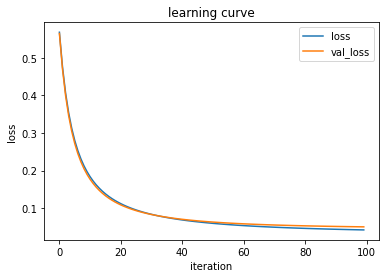

In [20]:
plt.plot(np.arange(my.iter), my.loss, label='loss')
plt.plot(np.arange(my.iter), my.val_loss, label='val_loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('learning curve')
plt.legend();

大体予想通り下がった

## 【問題7】決定領域の可視化
決定領域を可視化してください。

4次元では可視化できないので、２次元のデータセットに変更

In [21]:
X2_75 = X_75[:, 1:3]
X2_25 = X_25[:, 1:3]
X2_75.shape

(75, 2)

In [22]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


def decision_region(X, y, model, step=0.01, title='decision region', xlabel='Sepal length', ylabel='Petal length', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。
    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    a = np.min(X[:,0])-0.5 # Sepallabelの最小値-0.5
    b = np.max(X[:,0])+0.5 # Sepallabelの最大値+0.5
    c = np.min(X[:,1])-0.5 # Petallabelの最小値-0.5
    d = np.max(X[:,1])+0.5 # Petallabelの最小値+0.5
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(a, b, step), np.arange(c, d, step))
    
    e = np.ravel(mesh_f0) #列が全部指定したもの
    f = np.ravel(mesh_f1) #行が全部指定したもの
    
    mesh = np.c_[e,f] # グラフ領域(2次元)に左上から00.01-といった形で数字をつけた
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color)) # 等高線の間の色付
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)# 等高線の描画
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o') # 散布図の作成
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)] # よくわからんけど凡例の書き方を入れてる
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

In [23]:
my.fit(X2_75, y_75)

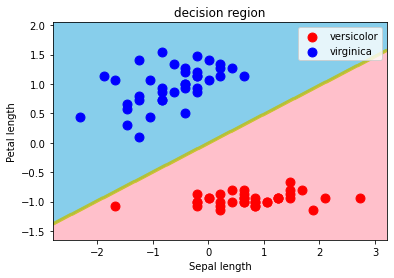

In [24]:
decision_region(X2_75, y_75['Species'], my)

## 【問題8】（アドバンス課題）重みの保存
検証が容易になるように、学習した重みを保存および読み込みができるようにしましょう。pickleモジュールやNumPyのnp.savezを利用します。

In [26]:
loss = my.loss
np.save('loss_test', loss)

In [29]:
np.load('loss_test.npy')

array([0.62574354, 0.56854375, 0.51982626, 0.4781218 , 0.44220908,
       0.41108864, 0.38394896, 0.36013294, 0.33910811, 0.3204417 ,
       0.30378044, 0.28883441, 0.27536433, 0.26317158, 0.25209024,
       0.24198098, 0.23272605, 0.22422544, 0.21639376, 0.20915768,
       0.20245399, 0.19622792, 0.19043179, 0.18502395, 0.17996786,
       0.17523136, 0.17078599, 0.16660654, 0.1626706 , 0.15895813,
       0.15545123, 0.15213383, 0.14899146, 0.14601106, 0.14318085,
       0.14049011, 0.13792914, 0.13548909, 0.13316188, 0.13094015,
       0.12881713, 0.12678662, 0.12484294, 0.12298083, 0.12119547,
       0.11948239, 0.11783745, 0.11625685, 0.11473702, 0.11327468,
       0.11186677, 0.11051042, 0.10920299, 0.10794199, 0.10672511,
       0.10555018, 0.10441516, 0.10331815, 0.10225738, 0.10123116,
       0.10023791, 0.09927616, 0.09834451, 0.09744163, 0.0965663 ,
       0.09571734, 0.09489363, 0.09409414, 0.09331787, 0.09256388,
       0.09183129, 0.09111925, 0.09042696, 0.08975366, 0.08909